In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [5]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [6]:
#disorder columns. 0/1 binary. these are dignoses for the disorders. 14 total
disorder_cols = ['SUB','TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [7]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SUB','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SUB'] = data['SUB'].apply(lambda x: 0 if x==-9 else 1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [8]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(100000, 50)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [57]:
model = Sequential()
model.add(Dense(10, input_shape=(36,), activation='relu'))
model.add(Dense(14, activation='relu'))

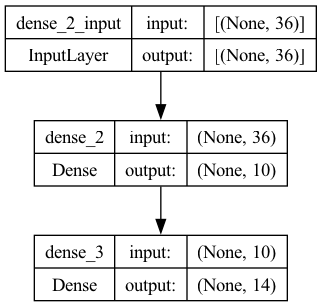

In [58]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
y = np.squeeze(data[disorder_cols])

In [61]:
print(X.shape, y.shape)

(100000, 36) (100000, 14)


In [62]:
from sklearn.model_selection import train_test_split

In [63]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
#fit the keras model on the dataset
#accuracy is likely computed using L2 norm, different from Hamming or num_correct
model.fit(X, y, epochs=2, batch_size=10)

Epoch 1/2
10000/10000 [==============================] - 46s 5ms/step - loss: 0.4649 - accuracy: 0.3072
Epoch 2/2
10000/10000 [==============================] - 47s 5ms/step - loss: 0.3669 - accuracy: 0.3852


In [67]:
model.predict(X_test[:1])

1/1 [==============================] - 0s 32ms/step


array([[0.        , 0.30335504, 0.16753714, 0.4673925 , 0.        ,
        0.        , 0.27270895, 0.        , 0.        , 0.        ,
        0.15093657, 0.        , 0.        , 0.07870372]], dtype=float32)

In [68]:
predictions = model.predict(X_test)
predictions_rounded = [[round(i) for i in a] for a in predictions]

625/625 [==============================] - 1s 1ms/step


In [48]:
def binary_encode(x):
    return np.array([sum(a[i]*2**i for i in range(len(a))) for a in x])

In [70]:
#when data includes multi-label (more than one 1's) accuracy score fails
pred_encoded = binary_encode(predictions_rounded)
y_test_encoded = binary_encode(np.array(y_test))
accuracy_score(y_test_encoded, pred_encoded)

0.0764

In [34]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [71]:
hamming_score(np.array(y_test), predictions_rounded)

0.15123166666666665